In [1]:
import optuna
from sklearn.linear_model import Ridge

import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Dense
from keras.layers import SimpleRNN
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam



from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

import tensorflow as tf
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

C:\Users\Lukasz\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# 0) SETTINGS

In [3]:
CSV_PATH = r"C:\\Users\\Lukasz\\Downloads\\ADANIPORTS.csv"

VOL_WINDOW = 21
ANNUALIZE = np.sqrt(252)

RET_THRESH = 0.30   # return clipping threshold
CAP_Q = 0.995       # cap volatility at train quantile

TEST_SIZE = 0.20
N_SPLITS_CV = 5     # for validation
RANDOM_STATE = 42

N_TRIALS = 50       # for tunning

# 1) LOAD DATA

In [5]:
df = pd.read_csv(CSV_PATH)

print("Raw shape:", df.shape)
print("Raw columns:", df.columns.tolist())

Raw shape: (3322, 15)
Raw columns: ['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble']


# 2) CLEANING

In [7]:
df = df.copy()
df.columns = [c.strip().replace("\n", " ") for c in df.columns]

if "Date" not in df.columns:
    raise ValueError("Column 'Date' not found.")

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# Drop constant identifier columns (single asset)
for col in ["Symbol", "Series"]:
    if col in df.columns and df[col].nunique(dropna=True) <= 1:
        df = df.drop(columns=[col])

# Drop columns often redundant/noisy
df = df.drop(columns=["Last"], errors="ignore")
df = df.drop(columns=["Trades"], errors="ignore")

print("\nAfter basic cleaning ---> shape:", df.shape)
print("Columns:", df.columns.tolist())


After basic cleaning ---> shape: (3322, 12)
Columns: ['Date', 'Symbol', 'Prev Close', 'Open', 'High', 'Low', 'Close', 'VWAP', 'Volume', 'Turnover', 'Deliverable Volume', '%Deliverble']


# 3) NUMERIC CASTING

In [9]:
numeric_candidates = [
    "Prev Close", "Open", "High", "Low", "Close", "VWAP", "Volume",
    "Turnover", "Deliverable Volume", "%Deliverble", "%Deliverable"
]
for c in numeric_candidates:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Inspect missing-value rates after numeric conversion
na_rate = (df.isna().mean().sort_values(ascending=False) * 100).head(15)
print("\nTop missing columns (%):")
print(na_rate)


Top missing columns (%):
Date                  0.0
Symbol                0.0
Prev Close            0.0
Open                  0.0
High                  0.0
Low                   0.0
Close                 0.0
VWAP                  0.0
Volume                0.0
Turnover              0.0
Deliverable Volume    0.0
%Deliverble           0.0
dtype: float64


# 4) EDA 

In [11]:
print("\nDate range:", df["Date"].min(), "->", df["Date"].max())
print("Rows:", len(df))


Date range: 2007-11-27 00:00:00 -> 2021-04-30 00:00:00
Rows: 3322


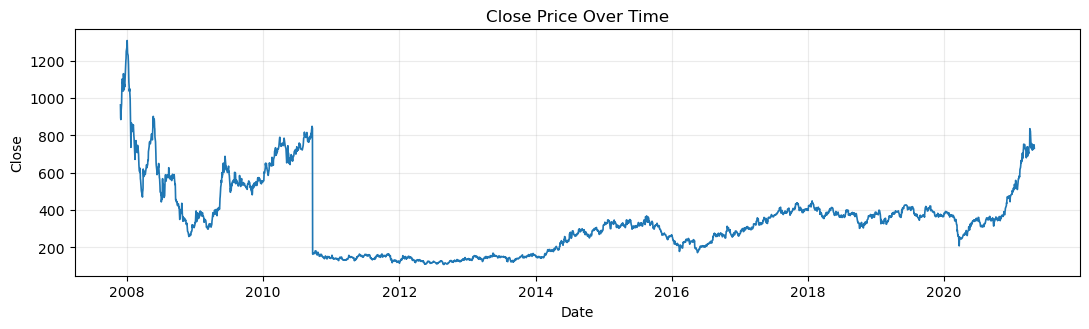

In [12]:
# Close price
if "Close" in df.columns:
    plt.figure(figsize=(11, 3.4))
    plt.plot(df["Date"], df["Close"], linewidth=1.2)
    plt.title("Close Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

- Price series contain trends and significant structural breaks in the long term. Therefore, it is more appropriate to work with yield and volatility-based variables rather than levels.

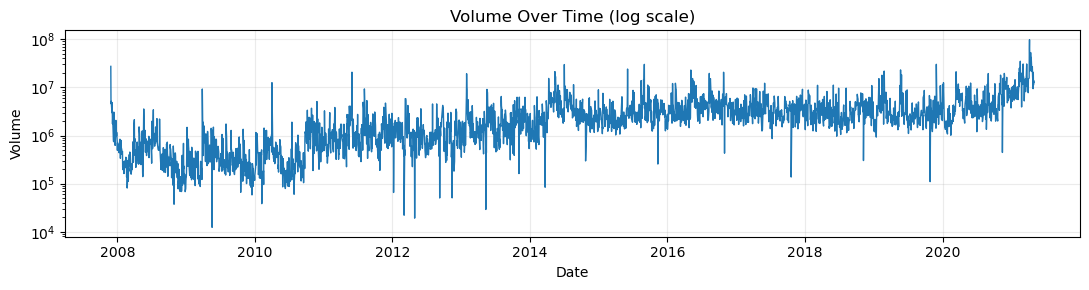

In [14]:
# Volume
if "Volume" in df.columns:
    plt.figure(figsize=(11, 3.0))
    plt.plot(df["Date"], df["Volume"], linewidth=1.0)
    plt.title("Volume Over Time (log scale)")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.yscale("log")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

- Volume shows high volatility and sudden jumps, indicating changing liquidity regimes. Although noisy, it is a complementary source of information for volatility.

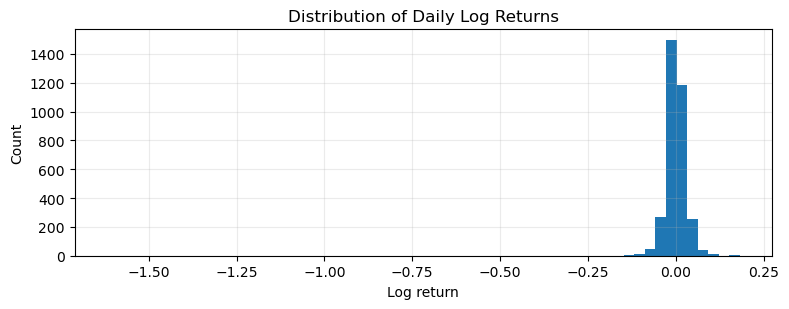

In [16]:
# Log return distribution
if "Close" in df.columns:
    tmp = df[["Close"]].copy()
    tmp["Log_Return"] = np.log(tmp["Close"] / tmp["Close"].shift(1))

    plt.figure(figsize=(8, 3.2))
    plt.hist(tmp["Log_Return"].dropna(), bins=60)
    plt.title("Distribution of Daily Log Returns")
    plt.xlabel("Log return")
    plt.ylabel("Count")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

- The distribution of daily log returns is concentrated around zero and exhibits distinctly thick tails. This reveals that financial return series deviate from a normal distribution and contain rare but extreme observations. This observation supports the rationale for applying clipping to log returns to prevent extreme returns from disproportionately affecting the calculation of realized volatility.

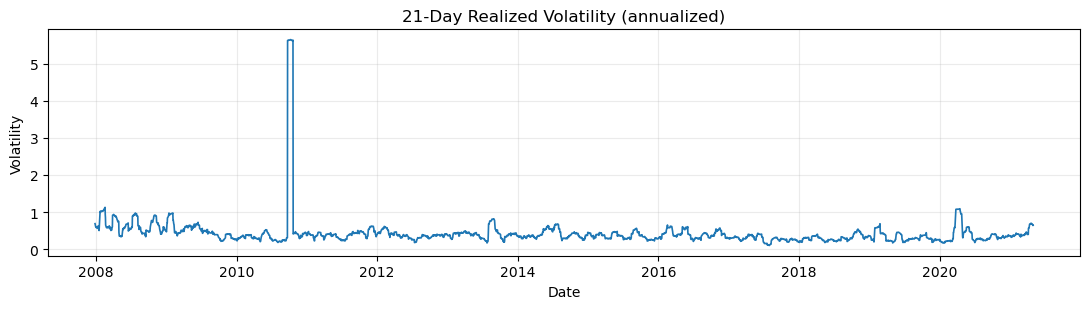

In [18]:
# 21-day(month) realized volatility time series
if "Close" in df.columns:
    tmp2 = df[["Date", "Close"]].copy()
    tmp2["Log_Return"] = np.log(tmp2["Close"] / tmp2["Close"].shift(1))
    tmp2["RV_21"] = tmp2["Log_Return"].rolling(21).std() * np.sqrt(252)

    plt.figure(figsize=(11, 3.2))
    plt.plot(tmp2["Date"], tmp2["RV_21"], linewidth=1.2)
    plt.title("21-Day Realized Volatility (annualized)")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

- The 21-day annualized realized volatility series shows significant volatility clustering and regime changes over time. Long periods of low volatility are interrupted by short but sharp volatility jumps, indicating that volatility is not stationary and varies over time. This structure confirms that the volatility estimation problem is meaningful and that the volatility capping approach is suitable for limiting the impact of extreme values ​​on the target variable.

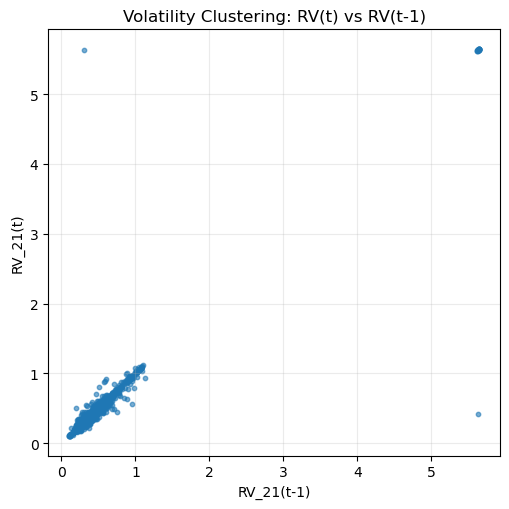

In [20]:
# Volatility clustering: RV(t) vs RV(t-1)
if "Close" in df.columns:
    tmp3 = tmp2.copy()
    tmp3["RV_21_lag1"] = tmp3["RV_21"].shift(1)
    scat = tmp3.dropna(subset=["RV_21", "RV_21_lag1"])

    plt.figure(figsize=(5.2, 5.2))
    plt.scatter(scat["RV_21_lag1"], scat["RV_21"], s=10, alpha=0.6)
    plt.xlabel("RV_21(t-1)")
    plt.ylabel("RV_21(t)")
    plt.title("Volatility Clustering: RV(t) vs RV(t-1)")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

- Comparing the realized volatility values ​​for consecutive days clearly shows a strong and positive relationship between RV(t) and RV(t−1). The concentration of the points largely around the 45-degree line reveals that volatility is highly persistent and that current volatility strongly explains the volatility of the next day. This finding explains the high performance of the persistence benchmark model and visually confirms the dominant role of past volatility in volatility prediction.

# 5) RETURNS + BASE RV 

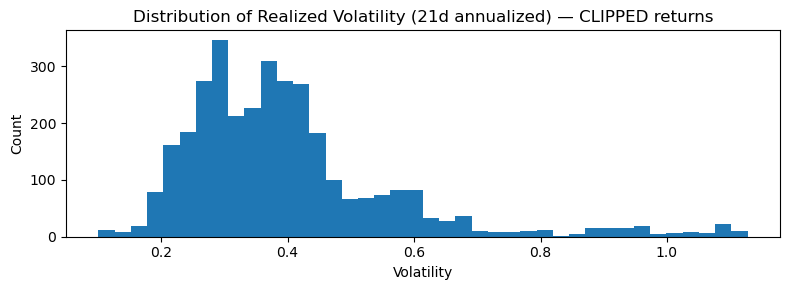

In [23]:
if "Close" not in df.columns:
    raise ValueError("'Close' is required.")

df["Log_Return_raw"] = np.log(df["Close"] / df["Close"].shift(1))

# DO NOT DROP ROWS >>> CLIP RETURNS
df["Log_Return"] = df["Log_Return_raw"].clip(-RET_THRESH, RET_THRESH)

# realized vol (based on clipped returns)
df["Volatility_raw"] = df["Log_Return_raw"].rolling(VOL_WINDOW).std() * ANNUALIZE
df["Volatility"] = df["Log_Return"].rolling(VOL_WINDOW).std() * ANNUALIZE

# quick plot
plt.figure(figsize=(8, 3))
plt.hist(df["Volatility"].dropna().values, bins=40)
plt.title("Distribution of Realized Volatility (21d annualized) — CLIPPED returns")
plt.xlabel("Volatility")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Daily Log Return
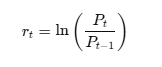

### 21-Day Realized Volatility
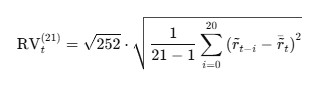

- Daily closing prices are first used to compute log returns, which represent the relative day-to-day price changes. Since financial return series often contain rare but extreme observations, return clipping (+/- 30) is applied to limit the impact of unusually large price movements without removing any observations from the dataset. This ensures that the time-series structure remains intact while preventing extreme returns from disproportionately inflating volatility estimates. Using these clipped returns, a 21-day rolling realized volatility series is then constructed and annualized. This procedure produces a more robust and stable volatility measure that still preserves the heavy-tailed nature of financial markets and provides a reliable target variable for volatility forecasting models.

# 6) FEATURE ENGINEERING (all past-only)

In [26]:
# SMAs
df["SMA_20"] = df["Close"].rolling(window=20).mean()
df["SMA_50"] = df["Close"].rolling(window=50).mean()

# RSI(14)
window = 14
delta = df["Close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(window=window, min_periods=window).mean()
avg_loss = loss.rolling(window=window, min_periods=window).mean()

rs = avg_gain / avg_loss.replace(0, np.nan)
df["RSI_14"] = 100 - (100 / (1 + rs))

# ATR(14)
prev_close = df["Close"].shift(1)
tr1 = (df["High"] - df["Low"]).abs()
tr2 = (df["High"] - prev_close).abs()
tr3 = (df["Low"] - prev_close).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df["ATR_14"] = tr.rolling(window=14, min_periods=14).mean()

# Return lags
df["Ret_lag1"] = df["Log_Return"].shift(1)
df["Ret_lag2"] = df["Log_Return"].shift(2)

- This block creates technical and return-based features using only past data. Moving averages capture short- and medium-term price trends, RSI summarizes recent momentum, and ATR measures recent price variability as a proxy for market uncertainty. Lagged returns are added to reflect short-term dynamics and volatility clustering. All features rely on rolling windows and lags, ensuring no future information is used.
  
- Feature engineering was performed prior to the train–test split because all constructed features rely exclusively on historical information and rolling windows. This ensures the absence of look-ahead bias and guarantees consistent feature definitions across the training and test sets.

# 7) DEFINE THE FORECAST TARGET (1-day ahead)

In [29]:
# Target >>> 1-day ahead realized volatility
# y_t = Volatility(t+1), computed from past returns only

df["Target"] = df["Volatility"].shift(-1)
target_name = "Volatility_fwd1"

print("\nTarget definition:", target_name)


Target definition: Volatility_fwd1


- This block defines the forecasting target as one-day-ahead realized volatility. Specifically, the model uses information available up to time 
"𝑡" to predict the realized volatility at time "𝑡+1". The target is constructed by shifting the realized volatility series forward by one day, which creates a genuine out-of-sample forecasting setup.

# 8) BUILD MODELING DATASET + TIME SPLIT

In [32]:
# Select feature set used for modeling
feature_candidates = [
    "Prev Close", "Open", "High", "Low", "Close", "VWAP", "Volume",
    "SMA_20", "SMA_50", "RSI_14", "ATR_14", "Ret_lag1", "Ret_lag2"
]
# Keep only features that exist in the dataset
feature_cols = [c for c in feature_candidates if c in df.columns]

# Build modeling dataset by removing rows with missing target or features (if they have)
df_model = df.dropna(subset=["Target"]).copy()
df_model = df_model.dropna(subset=feature_cols).reset_index(drop=True)

# Separate inputs and target
X = df_model[feature_cols]
y = df_model["Target"]

# Time-based train–test split (no shuffling)
split_idx = int(len(df_model) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:split_idx].copy(), X.iloc[split_idx:].copy()
y_train, y_test = y.iloc[:split_idx].copy(), y.iloc[split_idx:].copy()

print("\nFeatures planned to be used:", feature_cols)
print("Train size:", len(X_train), "| Test size:", len(X_test))
print("Train period:", df_model["Date"].iloc[0], "->", df_model["Date"].iloc[split_idx-1])
print("Test period :", df_model["Date"].iloc[split_idx], "->", df_model["Date"].iloc[-1])


Features planned to be used: ['Prev Close', 'Open', 'High', 'Low', 'Close', 'VWAP', 'Volume', 'SMA_20', 'SMA_50', 'RSI_14', 'ATR_14', 'Ret_lag1', 'Ret_lag2']
Train size: 2617 | Test size: 655
Train period: 2008-02-06 00:00:00 -> 2018-08-31 00:00:00
Test period : 2018-09-03 00:00:00 -> 2021-04-29 00:00:00


# 9) TARGET CAPPING (Training-Only Quantile Clipping)

In [34]:
cap_val = np.quantile(y_train.dropna().values, CAP_Q)
y_train_cap = y_train.clip(upper=cap_val)
y_test_cap  = y_test.clip(upper=cap_val)

print(f"\nTarget capping: cap_q={CAP_Q} learned on TRAIN only, cap={cap_val:.6f}")


Target capping: cap_q=0.995 learned on TRAIN only, cap=1.098820


- In this step, extreme values of the target variable are capped at a high quantile determined exclusively from the training set. Learning the cap from the training data only prevents information leakage, while limiting the influence of rare and extreme volatility spikes.

# 10) BASELINE

In [37]:
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def metrics_pack(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred))
    }

In [38]:
# Mean baseline
mean_hat = float(y_train_cap.mean())

# Train
y_train_mean = np.full_like(y_train_cap.values, mean_hat, dtype=float)
mean_train_metrics = metrics_pack(y_train_cap.values, y_train_mean)

# Test
y_test_mean = np.full_like(y_test_cap.values, mean_hat, dtype=float)
mean_test_metrics = metrics_pack(y_test_cap.values, y_test_mean)

In [39]:
print("\nBASELINE — TRAIN SET")
print("-------------------------------------------")
print(f"Mean baseline        | RMSE={mean_train_metrics['RMSE']:.6f} "
      f"MAE={mean_train_metrics['MAE']:.6f} R2={mean_train_metrics['R2']:.4f}")

print("\nBASELINE — TEST SET")
print("-------------------------------------------")
print(f"Mean baseline        | RMSE={mean_test_metrics['RMSE']:.6f} "
      f"MAE={mean_test_metrics['MAE']:.6f} R2={mean_test_metrics['R2']:.4f}")


BASELINE — TRAIN SET
-------------------------------------------
Mean baseline        | RMSE=0.163541 MAE=0.115537 R2=0.0000

BASELINE — TEST SET
-------------------------------------------
Mean baseline        | RMSE=0.171520 MAE=0.128200 R2=-0.0610


# NN

In [41]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

`StandardScaler()` is used to ensure that all features have comparable scale and to prevent certain features from dominating the learning process.

In [43]:
def build_model(input_dim, n_layers=2, n_units=64, activation="relu", learning_rate=0.001, dropout_rate=0.0):
    model = Sequential()
    
    # First layer with input_dim
    model.add(Dense(n_units, activation=activation, input_shape=(input_dim,)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Additional hidden layers
    for _ in range(n_layers - 1):
        model.add(Dense(n_units, activation=activation))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    # Output layer for regression
    model.add(Dense(1, activation="linear"))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    
    return model

# Hyperparameter grids
layer_grid      = [1, 2, 3]          
unit_grid       = [32, 64, 128]      
activation_grid = ["relu", "tanh"]  
epoch_grid      = [30, 50, 80]      
batch_grid      = [32, 64]        
lr_grid         = [0.001, 0.0001]    

# TimeSeries split
tscv = TimeSeriesSplit(n_splits=3)

# Early stopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Store best score and params
best_score = np.inf
best_params = None

# Grid search
total_combinations = len(layer_grid) * len(unit_grid) * len(activation_grid) * len(epoch_grid) * len(batch_grid) * len(lr_grid)
print(f"Total combinations to test: {total_combinations}")

for n_layers in layer_grid:
    for n_units in unit_grid:
        for activation in activation_grid:
            for epochs in epoch_grid:
                for batch_size in batch_grid:
                    for lr in lr_grid:

                        fold_losses = []

                        # TimeSeriesSplit
                        for train_idx, val_idx in tscv.split(X_train_scaled):
                            X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
                            y_tr, y_val = y_train_cap.iloc[train_idx], y_train_cap.iloc[val_idx]

                            # Build model
                            model = build_model(
                                input_dim=X_train_scaled.shape[1],
                                n_layers=n_layers,
                                n_units=n_units,
                                activation=activation,
                                learning_rate=lr
                            )

                            # Train model
                            history = model.fit(
                                X_tr, y_tr,
                                validation_data=(X_val, y_val),
                                epochs=epochs,
                                batch_size=batch_size,
                                shuffle=False,
                                callbacks=[early_stop],
                                verbose=0
                            )

                            # Store minimum validation loss for this fold
                            fold_losses.append(min(history.history["val_loss"]))

                        # Average validation loss across folds
                        avg_loss = np.mean(fold_losses)

                        # Update best params
                        if avg_loss < best_score:
                            best_score = avg_loss
                            best_params = {
                                "n_layers": n_layers,
                                "n_units": n_units,
                                "activation": activation,
                                "epochs": epochs,
                                "batch_size": batch_size,
                                "learning_rate": lr
                            }

                        print(f"Layers={n_layers}, Units={n_units}, Act={activation}, Epochs={epochs}, Batch={batch_size}, LR={lr} --> Avg val MSE={avg_loss:.6f}")

# Best hyperparameters
print("\nBest hyperparameters found:")
print(best_params)
print("Best CV MSE:", best_score)

Total combinations to test: 216
Layers=1, Units=32, Act=relu, Epochs=30, Batch=32, LR=0.001 --> Avg val MSE=0.076954
Layers=1, Units=32, Act=relu, Epochs=30, Batch=32, LR=0.0001 --> Avg val MSE=0.226252
Layers=1, Units=32, Act=relu, Epochs=30, Batch=64, LR=0.001 --> Avg val MSE=0.084460
Layers=1, Units=32, Act=relu, Epochs=30, Batch=64, LR=0.0001 --> Avg val MSE=0.156599
Layers=1, Units=32, Act=relu, Epochs=50, Batch=32, LR=0.001 --> Avg val MSE=0.177396
Layers=1, Units=32, Act=relu, Epochs=50, Batch=32, LR=0.0001 --> Avg val MSE=0.099788
Layers=1, Units=32, Act=relu, Epochs=50, Batch=64, LR=0.001 --> Avg val MSE=0.086977
Layers=1, Units=32, Act=relu, Epochs=50, Batch=64, LR=0.0001 --> Avg val MSE=0.143786
Layers=1, Units=32, Act=relu, Epochs=80, Batch=32, LR=0.001 --> Avg val MSE=0.062648
Layers=1, Units=32, Act=relu, Epochs=80, Batch=32, LR=0.0001 --> Avg val MSE=0.471443
Layers=1, Units=32, Act=relu, Epochs=80, Batch=64, LR=0.001 --> Avg val MSE=0.043316
Layers=1, Units=32, Act=relu

The function `build_model` constructs a feedforward neural network with some selected parameters. Below hyperparameter tuning is performed via Grid search. The folllowing hyperparameters are tuned:

Hyperparameters:

- `n_layers`: Number of hidden layers
- `n_units`: number of units in a layer
- `activation`: introduces non_linearity to a model
- `epochs`: number of epochs
- `batch_size`: Determines batch size
- `learning_rate`: Allows to control the pace of learning


Later, time series cross validation is implemented to insure that the temporal order of the data is preserved. Moreover, early stopping is implemented to monitor loss and stop training if no improvement is made for a set number of epochs (in our case `patiance = 10`. Lastly, best parameters are displayed and can be applied to build the final NN model.

In [45]:
# Build final NN model with best hyperparameters
final_model = build_model(
    input_dim=X_train_scaled.shape[1],
    n_layers=best_params["n_layers"],
    n_units=best_params["n_units"],
    activation=best_params["activation"],
    learning_rate=best_params["learning_rate"]
)

# Train final model on full training set
history = final_model.fit(
    X_train_scaled,
    y_train_cap,  
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    shuffle=False,  # preserve order
    verbose=1
)


Epoch 1/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1054 - mae: 0.2511
Epoch 2/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - mae: 0.1044
Epoch 3/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131 - mae: 0.0841
Epoch 4/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - mae: 0.0772
Epoch 5/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - mae: 0.0751
Epoch 6/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - mae: 0.0746
Epoch 7/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - mae: 0.0744
Epoch 8/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101 - mae: 0.0740
Epoch 9/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - mae: 0.0733
Epoch 10/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - mae: 0.0725
Epoch 11/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - mae: 0.0717
Epoch 12/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - mae: 0.0710
Epoch 13/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

In [46]:
y_train_pred = final_model.predict(X_train_scaled).ravel()
y_test_pred  = final_model.predict(X_test_scaled).ravel()

# Metrics
y_train_m = metrics_pack(y_train_cap, y_train_pred)
y_test_m  = metrics_pack(y_test_cap, y_test_pred)

# Output
print("\nNeural Network Model")
print("-------------------------------------------")
print("TRAIN SET (capped target)")
print(f"  RMSE: {y_train_m['RMSE']:.6f}")
print(f"  MAE : {y_train_m['MAE']:.6f}")
print(f"  R²  : {y_train_m['R2']:.4f}")
print("-----------------------")
print("TEST SET (capped target)")
print(f"  RMSE: {y_test_m['RMSE']:.6f}")
print(f"  MAE : {y_test_m['MAE']:.6f}")
print(f"  R²  : {y_test_m['R2']:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Neural Network Model
-------------------------------------------
TRAIN SET (capped target)
  RMSE: 0.075306
  MAE : 0.054433
  R²  : 0.7880
-----------------------
TEST SET (capped target)
  RMSE: 0.093473
  MAE : 0.064782
  R²  : 0.6849


The NN model performs slightly worse on unseen data as it displays a drop in $R^2$ value as well as slight increase in RMSE and MAE. It is expected as volatility can be difficult to predict.

In [48]:
baseline_mse, baseline_mae = final_model.evaluate(
    X_test_scaled,
    y_test,
    verbose=0
)

print("Baseline Test MSE:", baseline_mse)

Baseline Test MSE: 0.008737132884562016


In [49]:
def permutation_importance(
    model,
    X,
    y,
    metric="mse",
    n_repeats=10
):
    importances = {}

    for col_idx, col_name in enumerate(feature_cols):
        scores = []

        for _ in range(n_repeats):
            X_permuted = X.copy()

            # Permute one feature column
            np.random.shuffle(X_permuted[:, col_idx])

            loss, _ = model.evaluate(X_permuted, y, verbose=0)
            scores.append(loss)

        importances[col_name] = np.mean(scores)

    return importances


In [50]:
perm_importance = permutation_importance(
    model=final_model,
    X=X_test_scaled,
    y=y_test,
    n_repeats=10
)

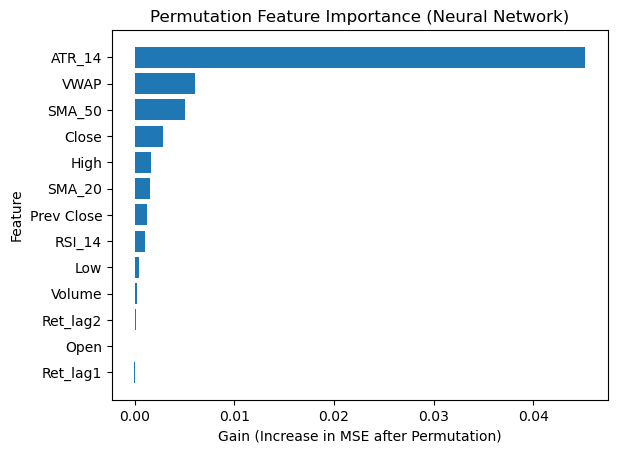

In [51]:
importance_df = pd.DataFrame({
    "feature": perm_importance.keys(),
    "mse_after_permutation": perm_importance.values()
})

importance_df["importance"] = (
    importance_df["mse_after_permutation"] - baseline_mse
)

importance_df = importance_df.sort_values(
    "importance", ascending=False
)

# Plot
plot_df = importance_df.sort_values("importance", ascending=True)

plt.figure()
plt.barh(plot_df["feature"], plot_df["importance"])
plt.xlabel("Gain (Increase in MSE after Permutation)")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance (Neural Network)")
plt.show()

Variable `ATR_14` seems to dominate the feature importance, however `VWAP` and `SMA_50` also have a decent influence on the model.

In [53]:
# Create a testset dataframe for analysis and visualization
preds_test = df_model.iloc[split_idx:].copy().reset_index(drop=True)

# Store actual target values, model predictions, and residuals
preds_test["y_true"] = y_test_cap.values
preds_test["y_pred"] = y_test_pred
preds_test["residual"] = preds_test["y_true"] - preds_test["y_pred"]

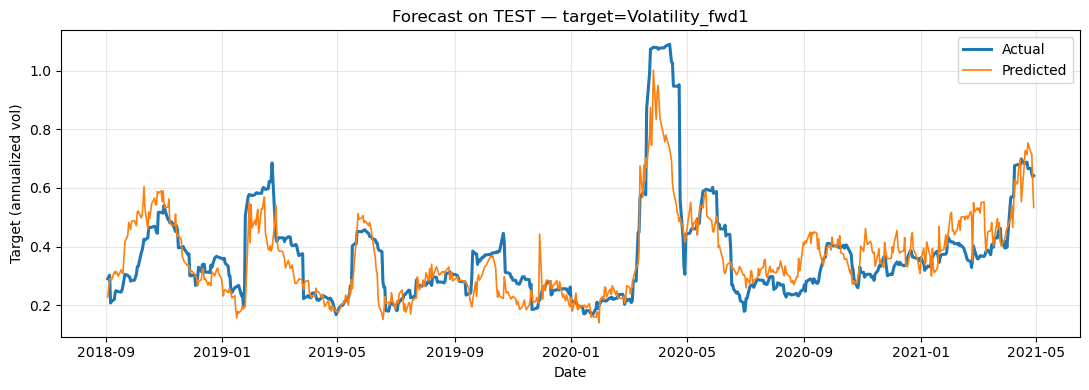

In [54]:
plt.figure(figsize=(11, 4))
plt.plot(preds_test["Date"], preds_test["y_true"], label="Actual", linewidth=2.2)
plt.plot(preds_test["Date"], preds_test["y_pred"], label="Predicted", linewidth=1.2)
plt.title(f"Forecast on TEST — target={target_name}")
plt.xlabel("Date")
plt.ylabel("Target (annualized vol)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

By comparing the Actual values of annualized volatility to the values predeicted by the model we can notice that in majority of cases the model predeicts the trends and spikes in a satisfying manner. There are rare instances when it is unable to predict a correct trend. It is, however, worth noting that since 2020-09 the model started to overestimate volatility.

# LSTM

Why was Long Short-Term Memory (LSTM) applied? Models such as feedforward NN treat all inputs independently and do not model temporal dependencies. By using LSTM we wanted to capture the sequential dependencies in this dataset. 

In [58]:
def build_lstm_model(input_shape, n_layers=1, n_units=64, activation="tanh", dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    
    # First LSTM layer
    if n_layers == 1:
        model.add(LSTM(n_units, activation=activation, input_shape=input_shape))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    else:
        # Return sequences for stacked LSTM
        model.add(LSTM(n_units, activation=activation, return_sequences=True, input_shape=input_shape))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
        
        # Additional LSTM layers
        for i in range(n_layers - 2):
            model.add(LSTM(n_units, activation=activation, return_sequences=True))
            if dropout_rate > 0:
                model.add(Dropout(dropout_rate))
        
        # Last LSTM layer returns single output
        model.add(LSTM(n_units, activation=activation))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    # Output layer for regression
    model.add(Dense(1, activation="linear"))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    
    return model

# Hyperparameter grids

layer_grid      = [1, 2]         
unit_grid       = [32, 64]      
activation_grid = ["tanh"]       
epoch_grid      = [30, 50]      
batch_grid      = [32, 64]        
lr_grid         = [0.001, 0.0005] 
dropout_grid    = [0.0, 0.2]     
LOOKBACK        = 20             

# Build sequences for full training set
def make_sequences(X, y, window):
    X_seq, y_seq = [], []
    for i in range(window, len(X)):
        X_seq.append(X[i-window:i])
        y_seq.append(y.iloc[i])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train_cap, LOOKBACK)

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

best_score = np.inf
best_params = None

# Grid search

total_combinations = len(layer_grid)*len(unit_grid)*len(activation_grid)*len(epoch_grid)*len(batch_grid)*len(lr_grid)*len(dropout_grid)
print(f"Total combinations to test: {total_combinations}")

for n_layers in layer_grid:
    for n_units in unit_grid:
        for activation in activation_grid:
            for dropout_rate in dropout_grid:
                for epochs in epoch_grid:
                    for batch_size in batch_grid:
                        for lr in lr_grid:

                            fold_losses = []

                            # TimeSeriesSplit
                            for train_idx, val_idx in tscv.split(X_train_seq):
                                X_tr, X_val = X_train_seq[train_idx], X_train_seq[val_idx]
                                y_tr, y_val = y_train_seq[train_idx], y_train_seq[val_idx]

                                model = build_lstm_model(
                                    input_shape=(LOOKBACK, X_train_seq.shape[2]),
                                    n_layers=n_layers,
                                    n_units=n_units,
                                    activation=activation,
                                    dropout_rate=dropout_rate,
                                    learning_rate=lr
                                )

                                history = model.fit(
                                    X_tr, y_tr,
                                    validation_data=(X_val, y_val),
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    shuffle=False,
                                    callbacks=[early_stop],
                                    verbose=0
                                )

                                fold_losses.append(min(history.history["val_loss"]))

                            avg_loss = np.mean(fold_losses)

                            if avg_loss < best_score:
                                best_score = avg_loss
                                best_params = {
                                    "n_layers": n_layers,
                                    "n_units": n_units,
                                    "activation": activation,
                                    "dropout_rate": dropout_rate,
                                    "epochs": epochs,
                                    "batch_size": batch_size,
                                    "learning_rate": lr
                                }

                            print(f"Layers={n_layers}, Units={n_units}, Act={activation}, Dropout={dropout_rate}, Epochs={epochs}, Batch={batch_size}, LR={lr} --> Avg val MSE={avg_loss:.6f}")

# Display best hyperparameters
print("\nBest LSTM hyperparameters:")
print(best_params)
print("Best CV MSE:", best_score)

# Build final LSTM model with best parameters
final_lstm_model = build_lstm_model(
    input_shape=(LOOKBACK, X_train_seq.shape[2]),
    n_layers=best_params["n_layers"],
    n_units=best_params["n_units"],
    activation=best_params["activation"],
    dropout_rate=best_params["dropout_rate"],
    learning_rate=best_params["learning_rate"]
)

# Train final model on full sequences
final_lstm_model.fit(
    X_train_seq,
    y_train_seq,
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    shuffle=False,
    verbose=1
)

Total combinations to test: 64
Layers=1, Units=32, Act=tanh, Dropout=0.0, Epochs=30, Batch=32, LR=0.001 --> Avg val MSE=0.018009
Layers=1, Units=32, Act=tanh, Dropout=0.0, Epochs=30, Batch=32, LR=0.0005 --> Avg val MSE=0.172373
Layers=1, Units=32, Act=tanh, Dropout=0.0, Epochs=30, Batch=64, LR=0.001 --> Avg val MSE=0.099778
Layers=1, Units=32, Act=tanh, Dropout=0.0, Epochs=30, Batch=64, LR=0.0005 --> Avg val MSE=0.256920
Layers=1, Units=32, Act=tanh, Dropout=0.0, Epochs=50, Batch=32, LR=0.001 --> Avg val MSE=0.024685
Layers=1, Units=32, Act=tanh, Dropout=0.0, Epochs=50, Batch=32, LR=0.0005 --> Avg val MSE=0.039182
Layers=1, Units=32, Act=tanh, Dropout=0.0, Epochs=50, Batch=64, LR=0.001 --> Avg val MSE=0.084058
Layers=1, Units=32, Act=tanh, Dropout=0.0, Epochs=50, Batch=64, LR=0.0005 --> Avg val MSE=0.029970
Layers=1, Units=32, Act=tanh, Dropout=0.2, Epochs=30, Batch=32, LR=0.001 --> Avg val MSE=0.038474
Layers=1, Units=32, Act=tanh, Dropout=0.2, Epochs=30, Batch=32, LR=0.0005 --> Avg v

A very similar function to the one used in a Neural Networks model was used here to implement LSTM. Moreover, hyperparameters were tuned in a similar manner as well. It was, however, important to prepare sequences in the case of LSTM. This is why the dataset was converted into sliding windows of length `LOOKBACK = 20`. Thanks to that each input sample contains 20 consecutive observations. This allows LSTM to capture temporal dependencies in volatility behaviour.
Hyperparameter tuning was performed via Grid Search again. 

Hyperparameters:

- `n_layers`: Number of hidden layers
- `n_units`: number of units in a layer
- `activation = tanh`: ensures stable learning process
- `dropout_rate` : Randomly deactivates neurons during training to prevent overfitting
- `epochs`: number of passes through data
- `batch_size`: Determines batch size
- `learning_rate`: Allows to control the pace of learning

Early stopping is implemented again to monitor `val_loss` and stop the model if no improvement is made for 10 epochs

In [61]:
X_test_seq, y_test_seq = make_sequences(
    X_test_scaled,
    y_test_cap,
    LOOKBACK
)
# Predictions using final LSTM
y_train_pred = final_lstm_model.predict(X_train_seq).ravel()
y_test_pred  = final_lstm_model.predict(X_test_seq).ravel()

# Metrics
y_train_m = metrics_pack(y_train_seq, y_train_pred)
y_test_m  = metrics_pack(y_test_seq, y_test_pred)

# Output
print("\nLSTM Model")
print("-------------------------------------------")
print("TRAIN SET (capped target)")
print(f"  RMSE: {y_train_m['RMSE']:.6f}")
print(f"  MAE : {y_train_m['MAE']:.6f}")
print(f"  R²  : {y_train_m['R2']:.4f}")
print("-----------------------")
print("TEST SET (capped target)")
print(f"  RMSE: {y_test_m['RMSE']:.6f}")
print(f"  MAE : {y_test_m['MAE']:.6f}")
print(f"  R²  : {y_test_m['R2']:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

LSTM Model
-------------------------------------------
TRAIN SET (capped target)
  RMSE: 0.064250
  MAE : 0.047456
  R²  : 0.8366
-----------------------
TEST SET (capped target)
  RMSE: 0.066023
  MAE : 0.046832
  R²  : 0.8459


The LSTM  model presents a much stronger predictive capability in comparison to the base Neural Networks model. The drop from train to test $R^2$ value is no longer noticable noticable and $R^2$ = 0.8459 on test data is very satisfactory. RMSE and MAE are also noticably lower than in the case of base Neural Network model. This highlights why choosing a model that can exploit sequential patterns was so important. 

In [64]:
# Number of initial rows lost due to lookback
LOOKBACK = 20

# Create LSTM-aligned test dataframe
preds_test_lstm = (
    df_model.iloc[split_idx + LOOKBACK:]
    .copy()
    .reset_index(drop=True)
)

# Store actual values, predictions, residuals
preds_test_lstm["y_true"] = y_test_seq
preds_test_lstm["y_pred"] = y_test_pred
preds_test_lstm["residual"] = (
    preds_test_lstm["y_true"] - preds_test_lstm["y_pred"]
)


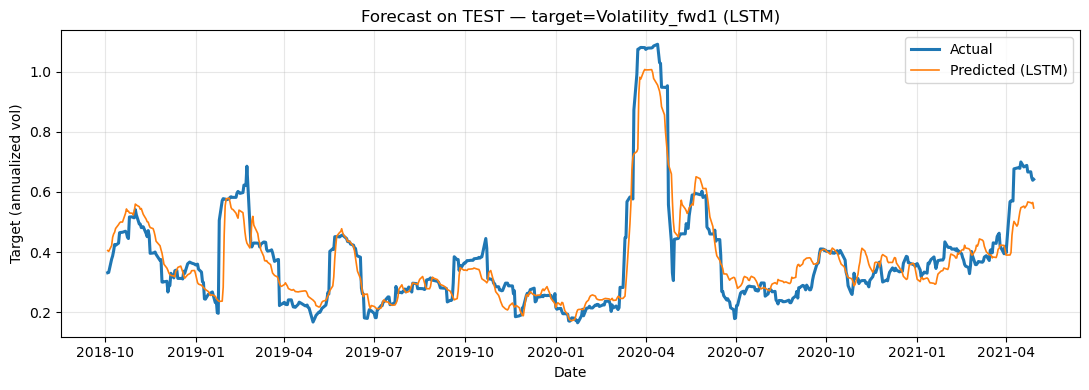

In [66]:
plt.figure(figsize=(11, 4))

plt.plot(
    preds_test_lstm["Date"],
    preds_test_lstm["y_true"],
    label="Actual",
    linewidth=2.2
)

plt.plot(
    preds_test_lstm["Date"],
    preds_test_lstm["y_pred"],
    label="Predicted (LSTM)",
    linewidth=1.2
)

plt.title(f"Forecast on TEST — target={target_name} (LSTM)")
plt.xlabel("Date")
plt.ylabel("Target (annualized vol)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The forecast on the test data in comparison to actual values presents satisfactory results. The trends are followed well and even though differences between actual and predicted values of volatility can be spotted, the overall performance is better than in case of base NN model